In [1]:
import os
import cv2

# Specify the path to the folder containing JPG files
folder_path = 'BTTAIxNYBG-train/BTTAIxNYBG-train'

In [2]:
import pandas as pd

# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('BTTAIxNYBG-train.csv')

# Display the first few rows of the DataFrame to verify that it was loaded correctly
print(df.head())


   uniqueID           classLabel  classID source             imageFile
0         2   occluded-specimens        8      L  a1a8b48e8cb142b3.jpg
1         3    microscope-slides        6      L  79599db2ac9092b6.jpg
2         4  illustrations-color        2    BHL  c449696f2f0d0d92.jpg
3         5  illustrations-color        2      P  80a8f4a393b4e08c.jpg
4         6     animal-specimens        0     AK  041a1c6e73313638.jpg


# Data Understanding

In [3]:
print("Shape of DataFrame:", df.shape)
print("Missing values:\n", df.isnull().sum())
duplicate_rows = df[df.duplicated()]
if duplicate_rows.empty:
    print("No duplicate rows.")
else:
    print("Duplicate rows:\n", duplicate_rows)
print("Summary statistics for numerical columns:\n", df.describe())
categorical_columns = ['classLabel', 'source']
for column in categorical_columns:
    print("Unique values in", column, ":", df[column].unique())

Shape of DataFrame: (81946, 5)
Missing values:
 uniqueID      0
classLabel    0
classID       0
source        0
imageFile     0
dtype: int64
No duplicate rows.
Summary statistics for numerical columns:
             uniqueID       classID
count   81946.000000  81946.000000
mean    61352.780612      4.499597
std     35478.300906      2.872108
min         2.000000      0.000000
25%     30617.250000      2.000000
50%     61169.500000      4.000000
75%     92146.500000      7.000000
max    122879.000000      9.000000
Unique values in classLabel : ['occluded-specimens' 'microscope-slides' 'illustrations-color'
 'animal-specimens' 'live-plants' 'biocultural-specimens'
 'illustrations-gray' 'mixed-pressed-specimens'
 'ordinary-pressed-specimens' 'micrographs-transmission-light']
Unique values in source : ['L' 'BHL' 'P' 'AK' 'US' 'C' 'BR' 'MICH' 'E' 'KY' 'F' 'K' 'NY' 'Tw' 'NMR'
 'CHNDM' 'MO' 'UA' 'Met' 'CAS' 'YPM' 'O' 'GH' 'FMNH' 'MPU' 'YU' 'UMMZ'
 'ASU' 'SDNHM' 'NHMD' 'UHIM' 'RSA' 'MCZ' 'MA' '

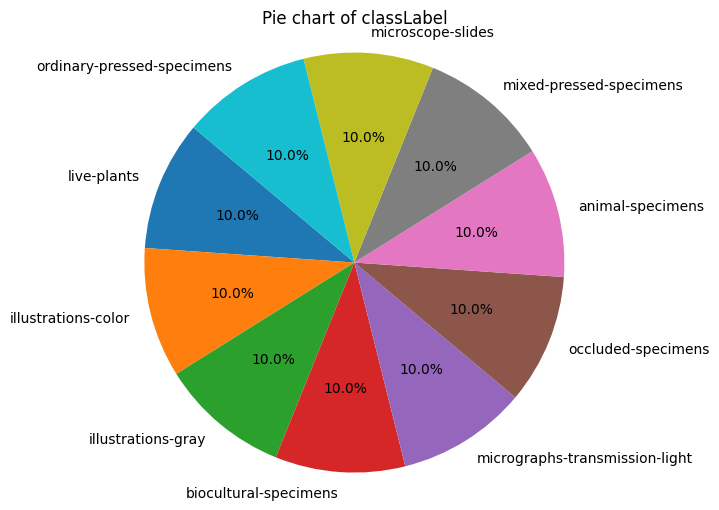

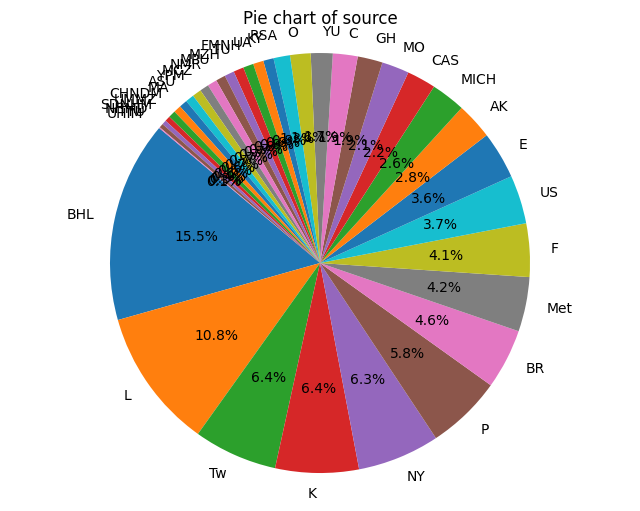

In [4]:
import matplotlib.pyplot as plt

# List of categorical columns
categorical_columns = ['classLabel', 'source']

# Plot pie charts for each categorical column
for column in categorical_columns:
    # Count the frequency of each category
    category_counts = df[column].value_counts()
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title("Pie chart of " + column)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
